In [5]:
import pandas as pd, numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
import matplotlib.pyplot as plt, seaborn as sns


In [6]:
# ---------- load ----------
csv_path = Path(r"C:\Users\SIMBY\Documents\climate_nasa.csv")
df = pd.read_csv(csv_path)

# ---------- handle missing ----------
df['text'] = df['text'].fillna("")
df['profileName'] = df['profileName'].fillna("Unknown")
df['likesCount'] = df['likesCount'].fillna(0)
df['commentsCount'] = df['commentsCount'].fillna(0)

# ---------- date features ----------
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.weekday

# ---------- encode profile ----------
encoder = LabelEncoder()
df['profile_encoded'] = encoder.fit_transform(df['profileName'])

# ---------- text vectorization ----------
tfidf = TfidfVectorizer(max_features=500, stop_words='english')
X_text = tfidf.fit_transform(df['text'])

# ---------- final dataset ----------
target = "likesCount"
X_meta = df[['commentsCount','year','month','day','weekday','profile_encoded']]
y = df[target]

X_final = hstack([X_text, X_meta.values])

print("Final feature matrix:", X_final.shape)
print("Target shape:", y.shape)


Final feature matrix: (522, 506)
Target shape: (522,)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=42
)

print("Training set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)


Training set: (417, 506) (417,)
Test set: (105, 506) (105,)


In [8]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42, n_estimators=100),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}


In [13]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate RMSE manually by taking the square root of MSE
    # This works with older versions of scikit-learn that don't have the squared parameter
    results[name] = {
        "MAE": mean_absolute_error(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),  # Take square root manually
        "R2": r2_score(y_test, y_pred)
    }

    print(f"\n{name} Results:")
    for metric, val in results[name].items():
        print(f"{metric}: {val:.4f}")


Linear Regression Results:
MAE: 19.1820
RMSE: 28.8888
R2: -3.6450

Random Forest Results:
MAE: 5.6184
RMSE: 15.0340
R2: -0.2580

Gradient Boosting Results:
MAE: 6.5893
RMSE: 16.4743
R2: -0.5106


,MAE,RMSE,R2
Linear Regression,19.181995,28.888850,-3.644972
Random Forest,5.618381,15.034011,-0.257976
Gradient Boosting,6.589283,16.474342,-0.510563


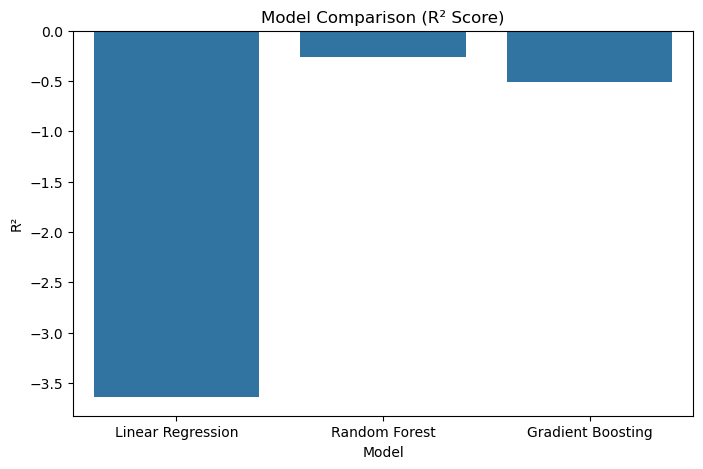

In [14]:
results_df = pd.DataFrame(results).T
display(results_df)

plt.figure(figsize=(8,5))
sns.barplot(data=results_df.reset_index(), x="index", y="R2")
plt.title("Model Comparison (R² Score)")
plt.ylabel("R²")
plt.xlabel("Model")
plt.show()
